## Normal RRI Analysis

In [513]:
quarterly_returns = pd.DataFrame(returns['Quarterly'])
monthly_returns = pd.DataFrame(returns['Monthly'])
weekly_returns = pd.DataFrame(returns['Weekly'])

In [497]:
timeframe = 'Quarterly'
freq = 4
market = 'SPX'
datelist = quarterly_dates_spx
portfolio_returns = quarterly_returns

def set_benchmark(title, dates):
    history = portfolio_returns[title]
    bench = pd.Series([(history.iloc[i]/history.iloc[i - 1] - 1) for i in range(1, len(history))])
    bench = bench.set_axis(dates[1:])
    return bench

bench_equal = set_benchmark(f'{market}/benchmark/ALL/{timeframe}/equal', datelist)
bench_mc = set_benchmark(f'{market}/benchmark/ALL/{timeframe}/marketcap', datelist)

metrics = {}
rf = 0

In [498]:
for t in portfolio_returns.keys():
    if market in t:
        history = portfolio_returns[t]
        ret = pd.Series([(history.iloc[i]/history.iloc[i - 1] - 1) for i in range(1, len(history))])
        ret = ret.set_axis(datelist[1:])
    
        win_rate = len(ret[ret > 0])/len(ret[ret != 0])
        sharpe = ((ret - rf).mean()/ret.std(ddof=1))*np.sqrt(freq)
        sortino = ((ret - rf).mean()/(np.sqrt((ret[ret < 0] ** 2).sum() / len(ret))))*np.sqrt(freq)
        information_equal = (ret - bench_equal).mean()/(ret - bench_equal).std()
        information_mc = (ret - bench_mc).mean()/(ret - bench_mc).std()
        rets = (ret + 1).cumprod()
        mx = rets.cummax()
        dds = rets/mx - 1
        
        metrics[t] = {}
        metrics[t]['Start Date'] = ret.index[0]
        metrics[t]['End Date'] = ret.index[-1]
        metrics[t]['Annual Return'] = rd(rets[-1] ** (1/(len(rets)/freq)) - 1)
        metrics[t]['Win Rate (weekly)'] = rd(win_rate*100)
        metrics[t]['Sharpe'] = rd(sharpe)
        metrics[t]['Sortino'] = rd(sortino)
        metrics[t]['InformationMarketCap'] = rd(information_mc)
        metrics[t]['InformationEqual'] = rd(information_equal)
        metrics[t]['Max Drawdown'] = rd(min(dds))
        
df = pd.DataFrame()
for t in portfolio_returns.keys():
    if market in t:
        df = pd.concat([df, pd.DataFrame.from_dict(metrics[t], orient='index', columns=[t])], axis=1)

df.to_csv(f'portfolio_metrics/{market}_{timeframe.lower()}_analysis_esg.csv', index=False)

C:\Users\anish\AppData\Local\Temp\ipykernel_48432\2913581643.py:11: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_48432\2913581643.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_48432\2913581643.py:10: RuntimeWarning:

invalid value encountered in double_scalars



In [505]:
spx_results = pd.read_csv('portfolio_metrics/spx_analysis_esg.csv')
spx_results.set_index('Portfolio', inplace=True)
spx_results = spx_results.drop(['Start', 'End'])
for col in spx_results:
    spx_results[col] = pd.to_numeric(spx_results[col])

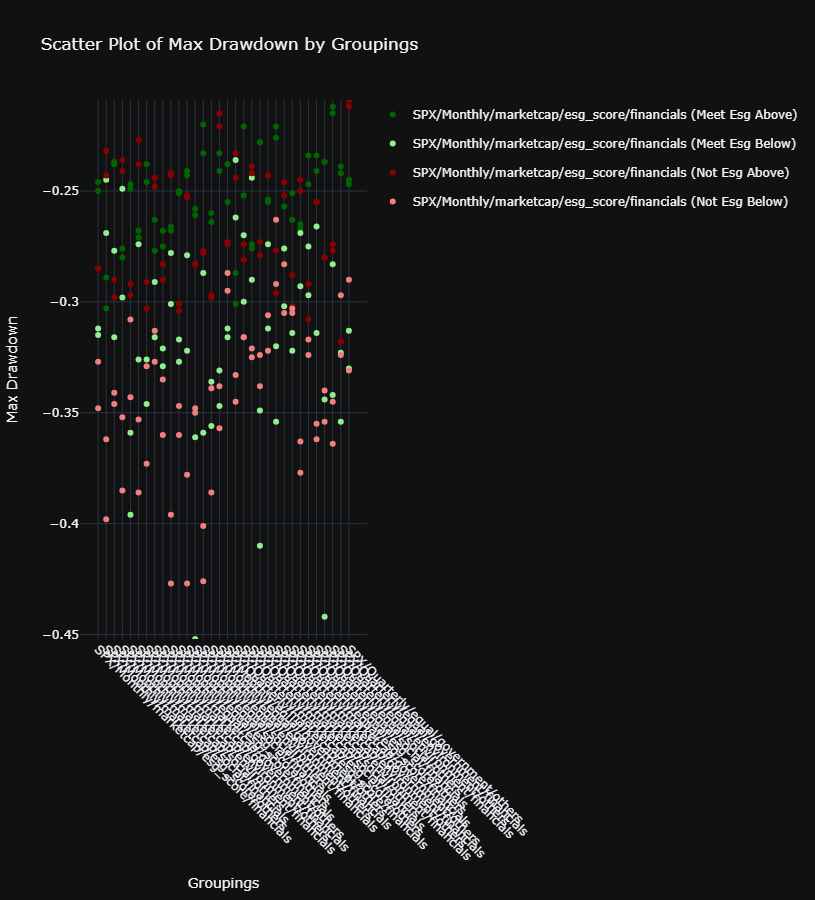

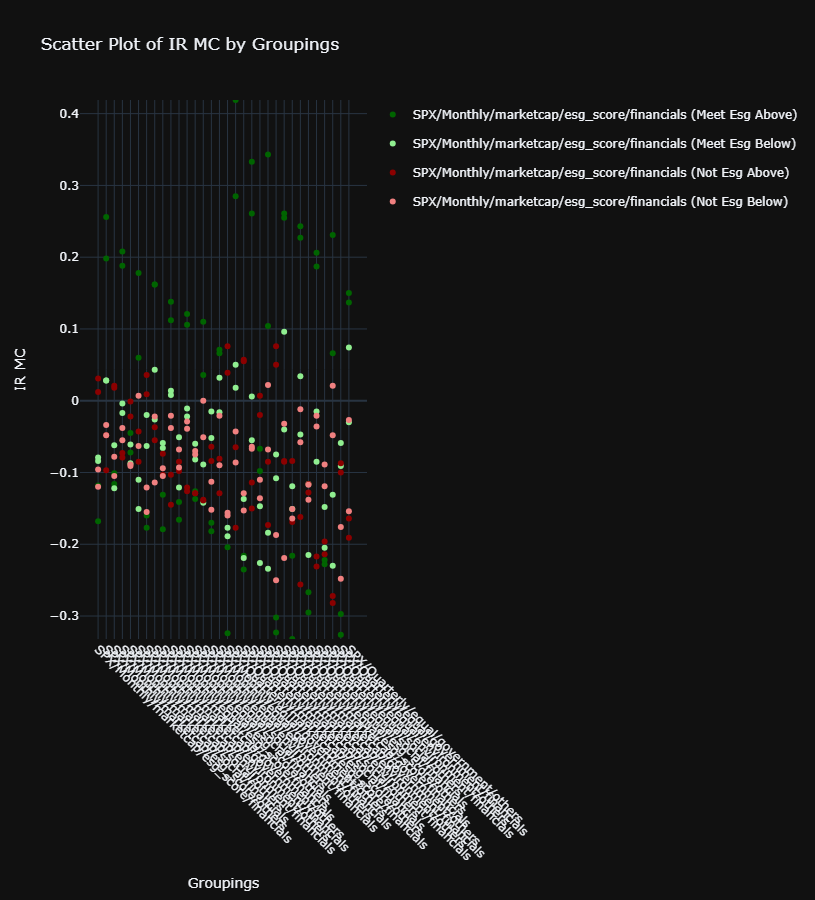

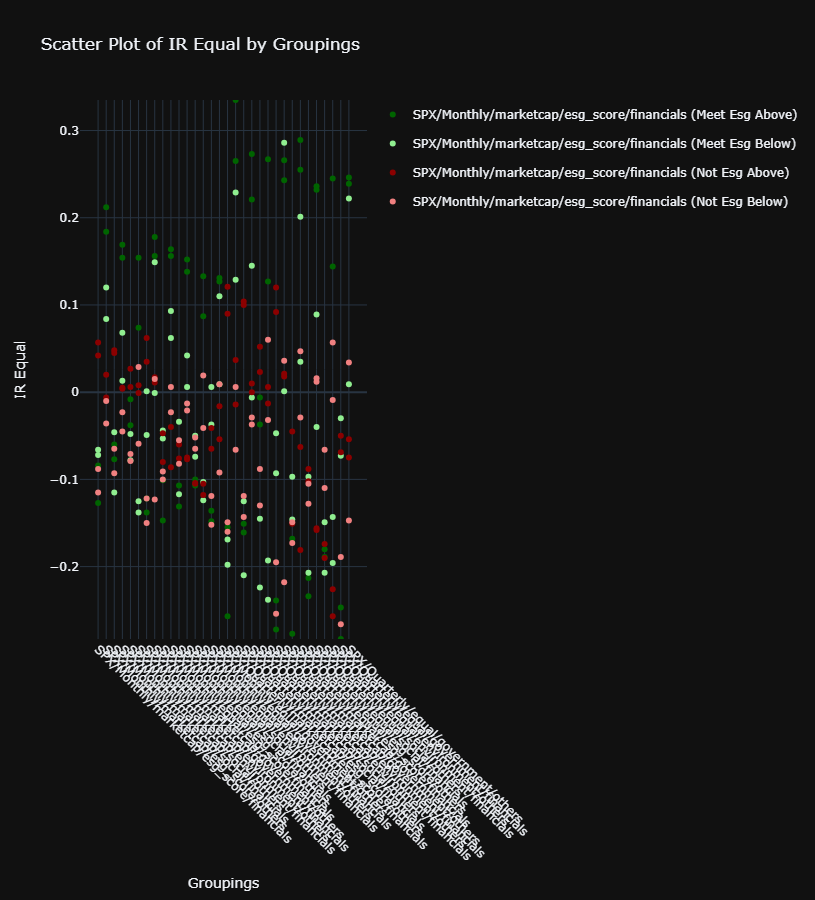

In [512]:
for metric in ['Max Drawdown', 'IR MC', 'IR Equal']:
    groupings = []
    
    for a in ['Monthly', 'Quarterly']:
        for c in ['marketcap', 'equal']:
            for d in ['esg_score', 'social', 'environment', 'government']:
                for e in ['financials', 'others']:
                    groupings.append(f'SPX/{a}/{c}/{d}/{e}')
    groupings = {x: {'meet_esg_above': [], 'meet_esg_below': [], 'not_esg_above': [], 'not_esg_below': []} for x in groupings}
    
    for col in spx_results.columns:
        title = 'SPX/'
        if 'Monthly' in col: title += 'Monthly/'
        elif 'Quarterly' in col: title += 'Quarterly/'
            
        if 'marketcap' in col: title += 'marketcap/'
        elif 'equal' in col: title += 'equal/'
            
        if 'social' in col: title += 'social/'
        elif 'government' in col: title += 'government/'
        elif 'environment' in col: title += 'environment/'
        elif 'esg_score' in col: title += 'esg_score/'
        else: continue
            
        if 'financials' in col: title += 'financials'
        elif 'others' in col: title += 'others'
    
        if 'meet_esg' in col: esg_type = 'meet_esg'
        elif 'not_esg' in col and 'zero' not in col: esg_type = 'not_esg'
        else: continue
    
        if 'above' in col: above_below = 'above'
        elif 'below' in col: above_below = 'below'
        else: continue
    
        key = f'{esg_type}_{above_below}'
        
        try:
            groupings[title][key].append(spx_results[col][metric])
        except Exception:
            print(title)
    
    color_map = {
        'meet_esg_above': 'darkgreen',
        'meet_esg_below': 'lightgreen',
        'not_esg_above': 'darkred',
        'not_esg_below': 'lightcoral'
    }
    
    fig = go.Figure()
    
    for key in groupings:
        for esg_key in groupings[key]:
            if groupings[key][esg_key]:
                fig.add_trace(go.Scatter(
                    x=[key]*len(groupings[key][esg_key]),
                    y=groupings[key][esg_key],
                    mode='markers',
                    name=f"{key} ({esg_key.replace('_', ' ').title()})",
                    marker=dict(color=color_map[esg_key]),
                    legendgroup=esg_key, 
                    showlegend=True if key == list(groupings.keys())[0] else False  
                ))
    
    fig.update_layout(
        template='plotly_dark',
        title=f'Scatter Plot of {metric} by Groupings',
        xaxis_title='Groupings',
        yaxis_title=metric,
        xaxis={
            'tickangle': 45, 
            'tickmode': 'array', 
            'tickvals': list(groupings.keys()), 
            'ticktext': list(groupings.keys())
        },
        yaxis=dict(range=[
            min([min(lst) for sublist in groupings.values() for lst in sublist.values() if lst]), 
            max([max(lst) for sublist in groupings.values() for lst in sublist.values() if lst])
        ]),
        showlegend=True,
        width=1500,
        height=900
    )
    
    fig.show()
    fig.write_html(f"spx_analysis_{metric}.html")


## Trend RRI Analysis